In [ ]:
"""
Tasks: 
-> load dataset
-> analysis
    [x] describe
    [x] boxplot
    -> outliers 
    [x] correlation 
    [x] regplot
-> preprocess
    [x] scale
    -> skew log1p
    -> dimension reduction
        [x] pca
        [x] kernel pca
        -> MDS -> RFE
        -> IsoMap -> RFE
        [x] Neighborhood Components Analysis
-> model
        [x] KneighborsRegressor
        [x] Kmeans Regression
        [x] Linear Regression
        [x] Ridge Regression
        [x] Polynomial Ridge
        -> Polynomial
        [x] SVR
        [x] Random Forest
        [x] DecisionTreeRegressor
        [x] GradientBoostingRegressor
-> metrics
    [x] R2
    -> adjusted R2
    [x] MSE
    [x] MAE


Report: 
- Abstract
- Introduction
    - Problem statement (Abstract)
    - Motivation
        - Why price prediction
        - ? Why use demension reduction
        - ? Why KMeans
    - Background
        - KNN Regression
        - Linear Regression, Ridge, Polynomial Ridge
        - SVR
        - Random Forest, Decision Tree Regression, Gradient Boosting Regression
    - Contribution
- Problem definition
    - Dataset
    - Formula
- Method
    - Preprocess data with Demension Reduction: 
        - Advantages
            - Reduce cocollinearity
            - Reduce computation
        - Method:
            - PCA
            - NCA
    - KMeans Regression
        - KMeans -> Cluster Mean
        - Comparing with KNN Regression
- Experiments
    - Metrics
    - Hyperparameters
    - All methods performance
    - Comparison between KMeans and KNN Regression
        - Error
        - Time
    - Comparision between with PCA and without PCA, with and without NCA
        - Cocollinearity
        - Time
        - Error
- Conclusion
- References


Note:
- Fold number in K-fold can effect the result, because the number of train data.
- When K = n_data in KMeans, KMeans Regression becomes to Kneighbors Regression where K = 1
"""

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint
import pickle
import os

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_is_fitted, check_X_y
from sklearn.base import BaseEstimator, RegressorMixin

import warnings
warnings.filterwarnings("ignore")

In [11]:
# output directory
dir_out = "out"
if not os.path.exists(dir_out):
    os.mkdir(dir_out)

### Load dataset

In [20]:
boston = load_boston()
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data["MEDV"] = boston.target

### Preprocess

In [21]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X = pd.DataFrame(StandardScaler().fit_transform(X), columns = boston.feature_names)

Dimention reduction: PCA

In [22]:
pca = PCA()
pca.fit(X)
pca_X = pca.transform(X)

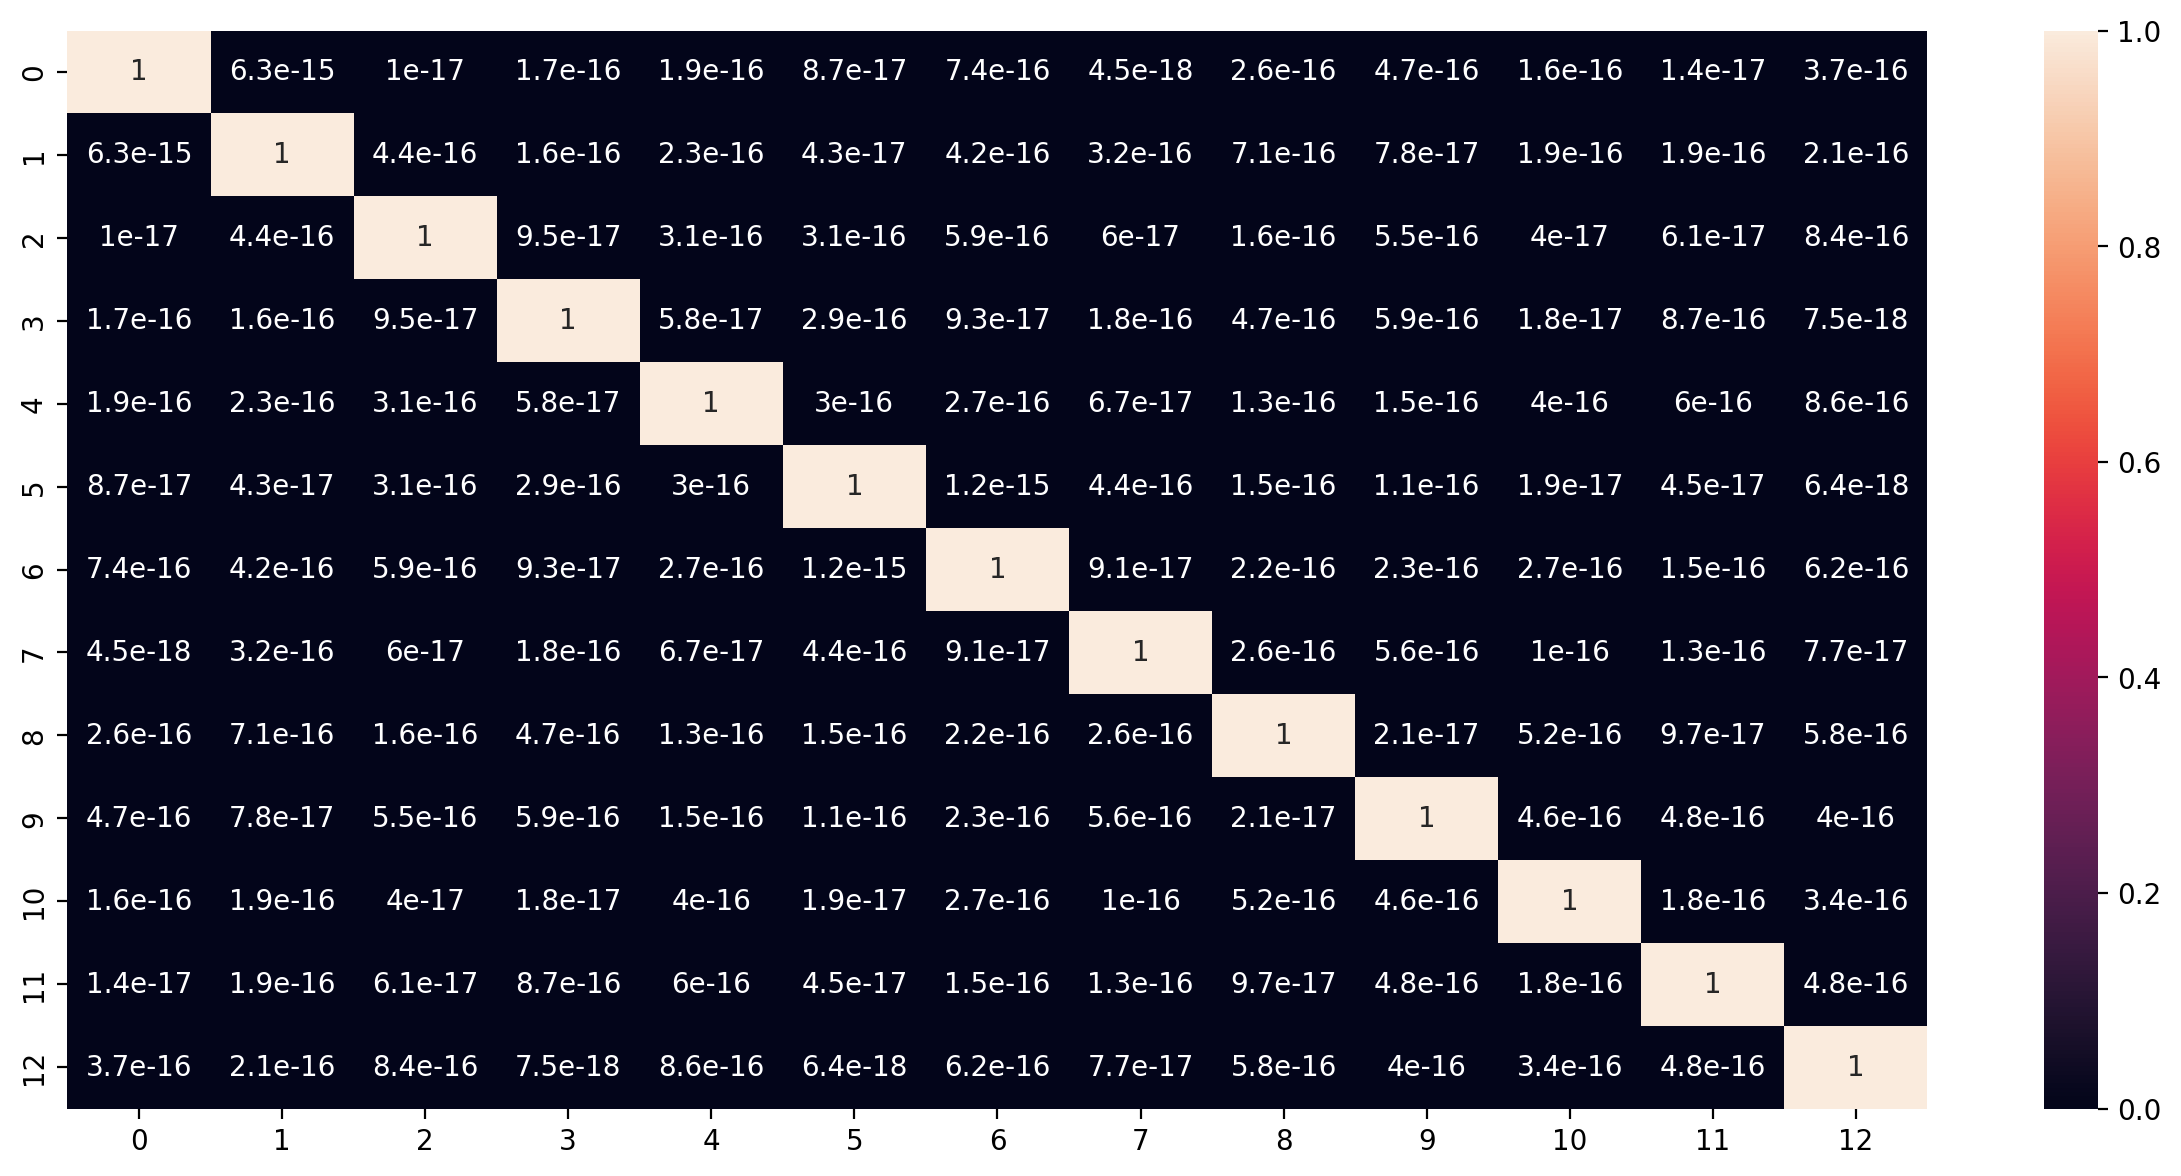

In [23]:
plt.figure(figsize = (15, 7), dpi = 200)
sns.heatmap(np.abs(np.corrcoef(pca_X, rowvar = False)),  annot=True)
plt.savefig(os.path.join(dir_out, f"PCA_heatmap"), bbox_inches='tight')

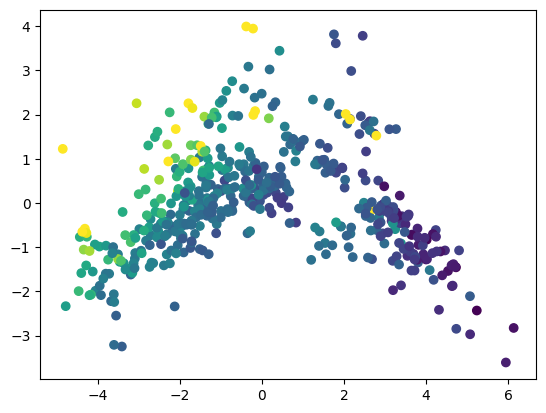

In [24]:
plt.scatter(pca_X[:, 0], pca_X[:, 1], c = y)
plt.savefig(os.path.join(dir_out, f"PCA_2d"), bbox_inches='tight')

[0.47129606 0.581548   0.67713389 0.74310121 0.80731782 0.8578876
 0.89906884 0.92953786 0.9508412  0.96778257 0.98209137 0.99511467
 1.        ]


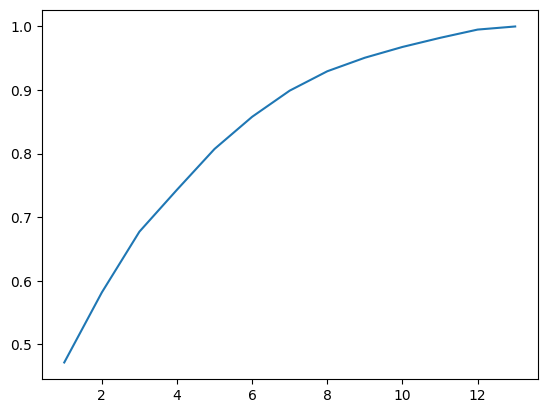

In [25]:
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_ratio) + 1), cum_ratio)
print(cum_ratio)
plt.savefig(os.path.join(dir_out, f"PCA_cum_ratio"), bbox_inches='tight')

Dimention reduction: Kernel PCA

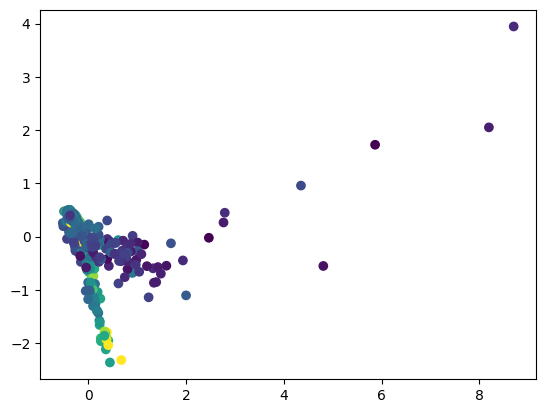

In [151]:
kpca = KernelPCA(kernel = "poly", gamma = 0.1, coef0 = 0, degree = 2)
kpca.fit(X)
kpca_X = kpca.transform(X)
plt.scatter(kpca_X[:, 0], kpca_X[:, 1], c = y)

[0.44229474 0.57695239 0.66241555 0.71010933 0.75110417 0.78230146
 0.8054906  0.82667833 0.84460222 0.85853675 0.87112825 0.88186592
 0.89197989]


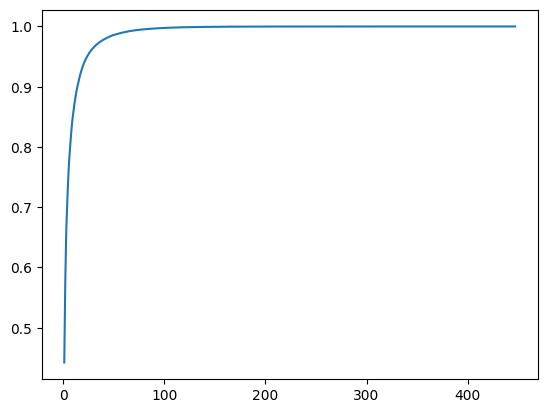

In [145]:
explained_variance = np.var(kpca_X, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cum_ratio = np.cumsum(explained_variance_ratio)
print(cum_ratio[:13])
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio))

Dimention reduction: NCA

In [27]:
nca = NeighborhoodComponentsAnalysis(n_components = 13)
n_clusters = 100
km = KMeans(n_clusters = 100)
y_cluster = km.fit_predict(y.to_numpy().reshape(-1, 1))
X_nca = nca.fit_transform(X, y = y_cluster)

<Figure size 3000x1400 with 0 Axes>

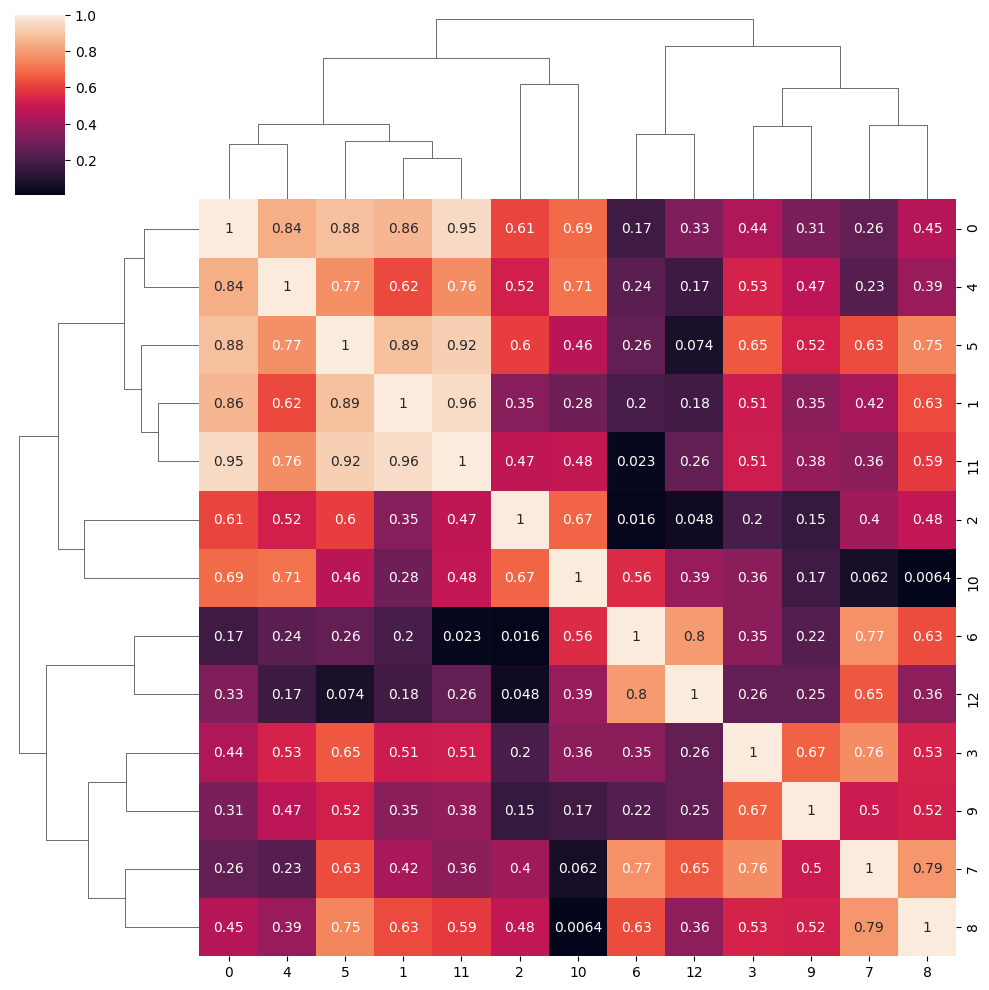

In [28]:
plt.figure(figsize = (15, 7), dpi = 200)
sns.clustermap(np.abs(np.corrcoef(X_nca, rowvar = False)),  annot=True)
plt.savefig(os.path.join(dir_out, f"NCA_heatmap"), bbox_inches='tight')

In [29]:
nca = NeighborhoodComponentsAnalysis(n_components = 2)
n_clusters = 100
km = KMeans(n_clusters = 100)
y_cluster = km.fit_predict(y.to_numpy().reshape(-1, 1))
X_nca = nca.fit_transform(X, y = y_cluster)

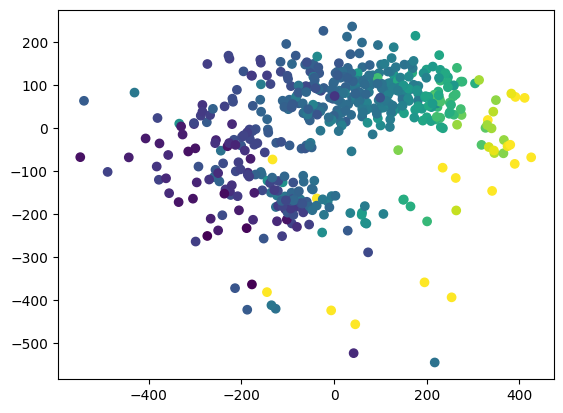

In [30]:
plt.scatter(X_nca[:, 0], X_nca[:, 1], c = y)
plt.savefig(os.path.join(dir_out, f"NCA_2d"), bbox_inches='tight')

Skewness

In [226]:
# Skewness??
# for col in X:
#     if np.abs(X[col].skew()) > 0.3:
#         X[col] = np.log1p(X[col])
# y = np.log1p(y)
# log1p_inverse = lambda x: np.e ** x - 1

### Model

Custom models

In [7]:
class KMeansRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, n_neighbors = 1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        check_X_y(X, y)
        X = np.asarray(X, dtype = float)
        y = np.asarray(y)
        self.X_ = X
        self.y_ = y

        n_data = len(X)
        self.km_ = KMeans(n_clusters = n_data // self.n_neighbors)
        clusters = self.km_.fit_predict(X)
        self.cluster_ys_ = [[] for i in range(self.km_.n_clusters)]
        for i, cluster in enumerate(clusters):
            # print(self.y_)
            self.cluster_ys_[cluster].append(self.y_[i])
        self.cluster_y_ = np.asarray([np.mean(ys) for ys in self.cluster_ys_])

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = np.asarray(X, dtype = float)
        cluster = self.km_.predict(X)
        cluster = cluster.astype(int)
        return self.cluster_y_[cluster]
        

class NCARegressor(BaseEstimator, RegressorMixin):

    def __init__(self, n_components, regressor, y_min, y_max, n_neighbors = 5):
        self.n_components = n_components
        self.regressor = regressor
        self.n_neighbors = n_neighbors
        self.y_min = y_min
        self.y_max = y_max

    def fit(self, X, y):
        check_X_y(X, y)
        X = np.asarray(X)
        y = np.asarray(y)
        self.X_ = X
        self.y_ = y
        self.nca_ = NeighborhoodComponentsAnalysis(n_components = self.n_components)
        
        assert X.shape[1] >= self.n_components
        n_clusters = X.shape[0] // self.n_neighbors
        y_fake = np.linspace(self.y_min, self.y_max, n_clusters)
        km = KMeans(n_clusters = n_clusters).fit(y_fake.reshape(-1, 1))
        # km = KMeans(n_clusters = n_clusters).fit(y.reshape(-1, 1))
        y_cluster = km.predict(y.reshape(-1, 1))

        self.X_nca_ = self.nca_.fit_transform(X, y = y_cluster)
        self.regressor.fit(self.X_nca_, self.y_)

    def predict(self, X):
        X_nca = self.nca_.transform(X)
        return self.regressor.predict(X_nca)
    

class PCARegressor(BaseEstimator, RegressorMixin):

    def __init__(self, n_components, regressor):
        self.n_components = n_components
        self.regressor = regressor

    def fit(self, X, y):
        check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.pca_ = PCA(n_components = self.n_components)
        self.pca_.fit(X)
        X_pca = self.pca_.transform(X)
        self.regressor.fit(X_pca, y)

    def predict(self, X):
        X_pca = self.pca_.transform(X)
        return self.regressor.predict(X_pca)




Metrics

In [8]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]

Choose hyperparameters

In [ ]:
print("{:-^40}".format(f" K-means Regression "))

gs_km = GridSearchCV(
    KMeansRegressor(n_neighbors = 5),
    param_grid = {
        "n_neighbors": [1, 2, 3, 5, 7, 9, 11],
    },
    cv = 10,
    scoring = scoring,
    refit = "neg_mean_squared_error"
)
gs_km.fit(X, y)

pprint(gs_km.best_estimator_.get_params())

---------- KMeans Regression -----------
{'n_neighbors': 7}


In [54]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "SVR": SVR(kernel = 'rbf', C = 1e3, gamma = 0.1),
    "K Nearest Neighbor": KNeighborsRegressor(n_neighbors = 7),
    "Gradient Boost": GradientBoostingRegressor(alpha = 0.9,learning_rate = 0.05, 
                                                max_depth = 2, min_samples_leaf = 5, 
                                                min_samples_split = 2, n_estimators = 100),
    "Decision Tree": DecisionTreeRegressor(max_depth = 5),
    "Random Forest": RandomForestRegressor(),
    "K-means Regression": KMeansRegressor(n_neighbors = 7),
}

gss_nca = {}

for name, model in models.items():

    print("{:-^40}".format(f" NCA + {name} "))

    gs = GridSearchCV(
        NCARegressor(n_components = 5, regressor = model, y_min = 5, y_max = 50, n_neighbors = 5),
        param_grid = {
            "n_components": [1, 2, 3, 5, 7, 9],
            "n_neighbors": [3, 5, 8, 10, 20, 40, 100]
        },
        cv = 10,
        scoring = scoring,
        refit = "neg_mean_squared_error"
    )
    gs.fit(X, y)

    gss_nca[name] = gs
    pprint(gs.best_estimator_.get_params())

------- NCA + Linear Regression --------
{'n_components': 1,
 'n_neighbors': 10,
 'regressor': LinearRegression(),
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'y_max': 50,
 'y_min': 5}
------------- NCA + Ridge --------------
{'n_components': 9,
 'n_neighbors': 20,
 'regressor': Ridge(),
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.001,
 'y_max': 50,
 'y_min': 5}
----------- NCA + Poly Ridge -----------
{'n_components': 1,
 'n_neighbors': 10,
 'regressor': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())]),
 'regressor__memory': None,
 'regressor__polynomialfeatures': PolynomialFeatures(deg

In [52]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "SVR": SVR(kernel = 'rbf', C = 1e3, gamma = 0.1),
    "K Nearest Neighbor": KNeighborsRegressor(n_neighbors = 7),
    "Gradient Boost": GradientBoostingRegressor(alpha = 0.9,learning_rate = 0.05, 
                                                max_depth = 2, min_samples_leaf = 5, 
                                                min_samples_split = 2, n_estimators = 100),
    "Decision Tree": DecisionTreeRegressor(max_depth = 5),
    "Random Forest": RandomForestRegressor(),
    "K-means Regression": KMeansRegressor(n_neighbors = 7),
}

gss_pca = {}

for name, model in models.items():

    print("{:-^40}".format(f" PCA + {name} "))

    gs = GridSearchCV(
        PCARegressor(n_components = 5, regressor = model),
        param_grid = {
            "n_components": [1, 2, 3, 5, 7, 9, 11],
        },
        cv = 10,
        scoring = scoring,
        refit = "neg_mean_squared_error"
    )
    gs.fit(X, y)

    gss_pca[name] = gs
    pprint(gs.best_estimator_.get_params())

------- PCA + Linear Regression --------
{'n_components': 9,
 'regressor': LinearRegression(),
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__n_jobs': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False}
------------- PCA + Ridge --------------
{'n_components': 9,
 'regressor': Ridge(),
 'regressor__alpha': 1.0,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__max_iter': None,
 'regressor__normalize': 'deprecated',
 'regressor__positive': False,
 'regressor__random_state': None,
 'regressor__solver': 'auto',
 'regressor__tol': 0.001}
----------- PCA + Poly Ridge -----------
{'n_components': 3,
 'regressor': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())]),
 'regressor__memory': None,
 'regressor__polynomialfeatures': PolynomialFeatures(degree=3),
 'regressor__polynomialfeatures__degree': 3,
 'regressor__polynomialfeatures__include_bias': True,
 'regre

In [14]:
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Gradient Boost': GradientBoostingRegressor(learning_rate=0.05, max_depth=2, min_samples_leaf=5),
    'K Nearest Neighbor': KNeighborsRegressor(n_neighbors=7),
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Ridge': Ridge(),
    'SVR': SVR(C=1000.0, gamma=0.1),
    'K-means Regression': KMeansRegressor(n_neighbors=7),
    'NCA + Decision Tree': NCARegressor(n_components=1, n_neighbors=10,
                regressor=DecisionTreeRegressor(max_depth=5), y_max=50, y_min=5),
    'NCA + Gradient Boost': NCARegressor(n_components=9, n_neighbors=20,
                regressor=GradientBoostingRegressor(learning_rate=0.05,
                                                    max_depth=2,
                                                    min_samples_leaf=5),
                y_max=50, y_min=5),
    'NCA + K Nearest Neighbor': NCARegressor(n_components=3, n_neighbors=10,
                regressor=KNeighborsRegressor(n_neighbors=7), y_max=50, y_min=5),
    'NCA + Linear Regression': NCARegressor(n_components=1, n_neighbors=10, regressor=LinearRegression(),
                y_max=50, y_min=5),
    'NCA + Random Forest': NCARegressor(n_components=9, n_neighbors=20, regressor=RandomForestRegressor(),
                y_max=50, y_min=5),
    'NCA + Ridge': NCARegressor(n_components=9, n_neighbors=20, regressor=Ridge(), y_max=50,
                y_min=5),
    'NCA + SVR': NCARegressor(n_components=2, n_neighbors=100,
                regressor=SVR(C=1000.0, gamma=0.1), y_max=50, y_min=5),
    'NCA + K-means Regression': NCARegressor(n_components=1, n_neighbors=8,
                regressor=KMeansRegressor(n_neighbors=7), y_max=50, y_min=5),
    'PCA + Decision Tree': PCARegressor(n_components=3, regressor=DecisionTreeRegressor(max_depth=5)),
    'PCA + Gradient Boost': PCARegressor(n_components=7,
                regressor=GradientBoostingRegressor(learning_rate=0.05,
                                                    max_depth=2,
                                                    min_samples_leaf=5)),
    'PCA + K Nearest Neighbor': PCARegressor(n_components=5, regressor=KNeighborsRegressor(n_neighbors=7)),
    'PCA + Linear Regression': PCARegressor(n_components=9, regressor=LinearRegression()),
    'PCA + Random Forest': PCARegressor(n_components=11, regressor=RandomForestRegressor()),
    'PCA + Ridge': PCARegressor(n_components=9, regressor=Ridge()),
    'PCA + SVR': PCARegressor(n_components=3, regressor=SVR(C=1000.0, gamma=0.1)),
    'PCA + K-means Regression': PCARegressor(n_components=11, regressor=KMeansRegressor(n_neighbors=7))
}

### Train and test models

In [16]:
results = {}

for name, model in models.items():
    result = cross_validate(model, X, y, cv = 10, scoring = scoring)
    for key in result:
        results.setdefault(key, {})
        results[key][name] = result[key]

Save results

In [17]:
with open("results.pkl", "wb") as f:
    pickle.dump(results, f)

In [5]:

with open("results.pkl", "rb") as f:
    results = pickle.load(f)

Plot Results

Box plot 

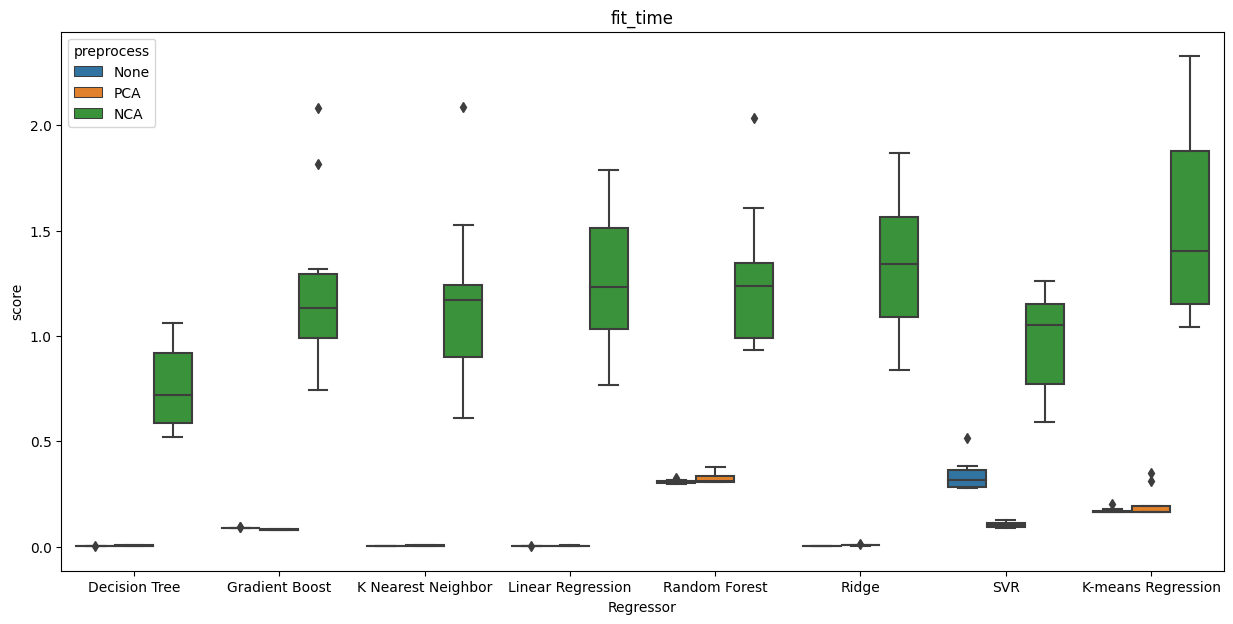

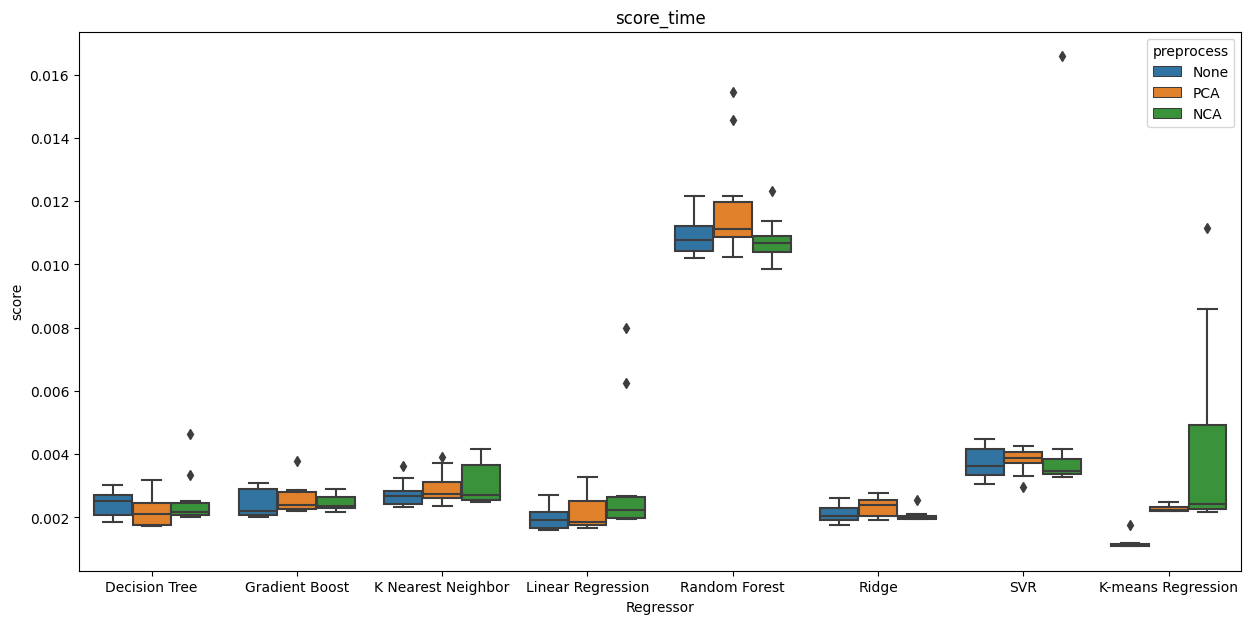

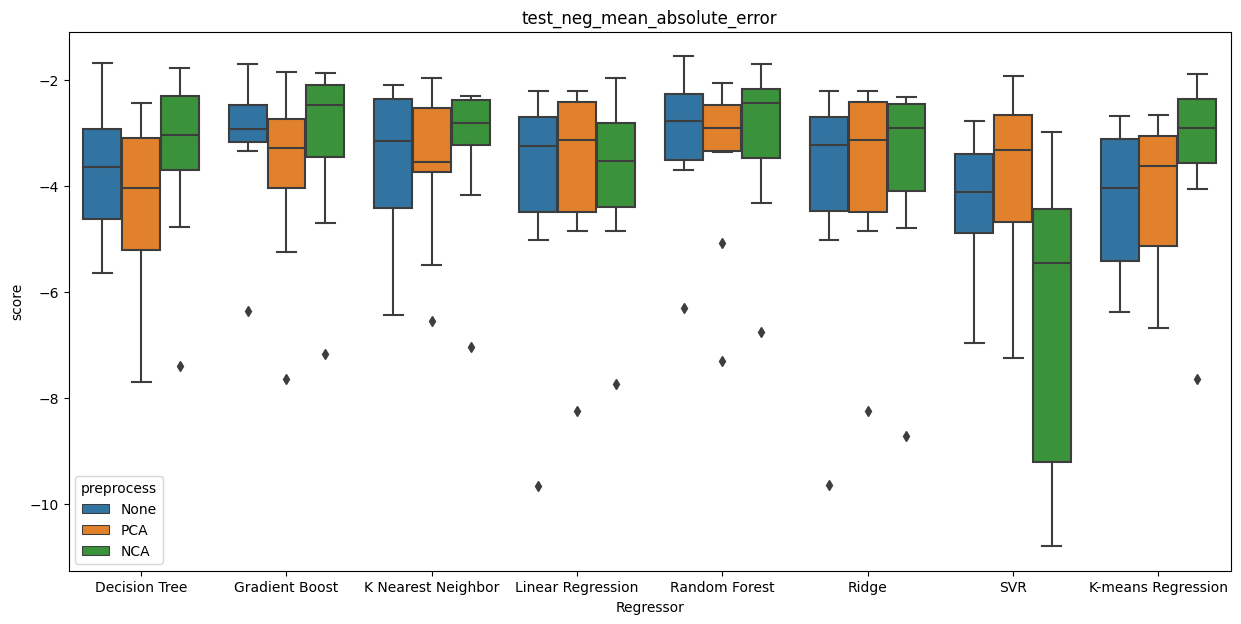

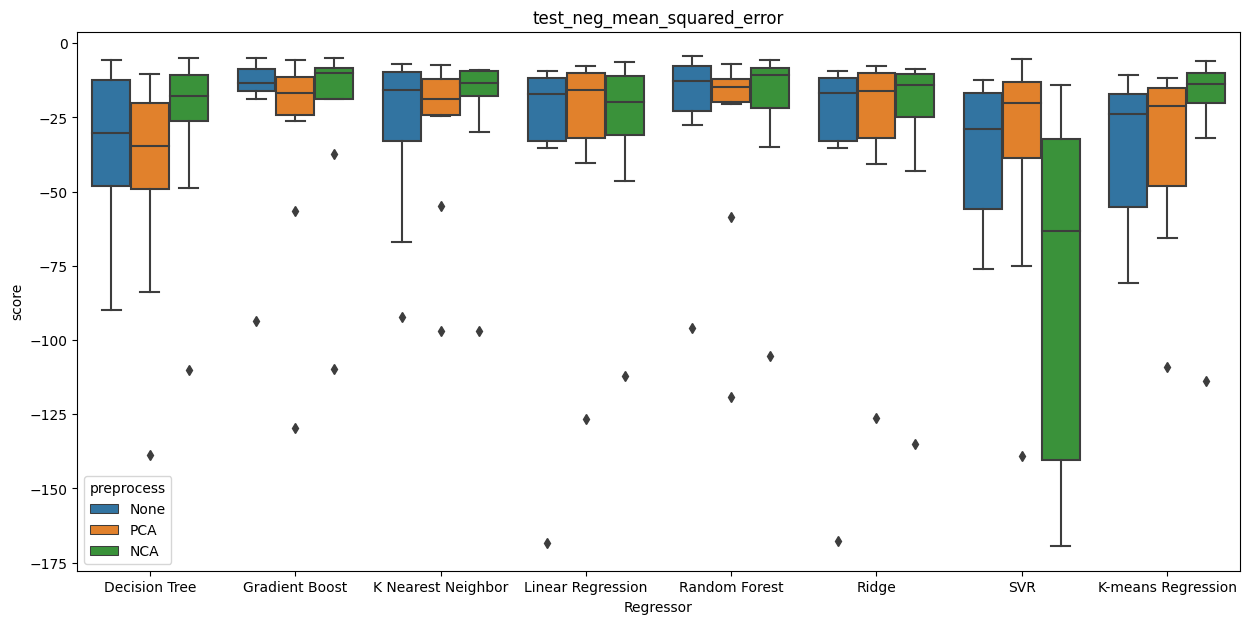

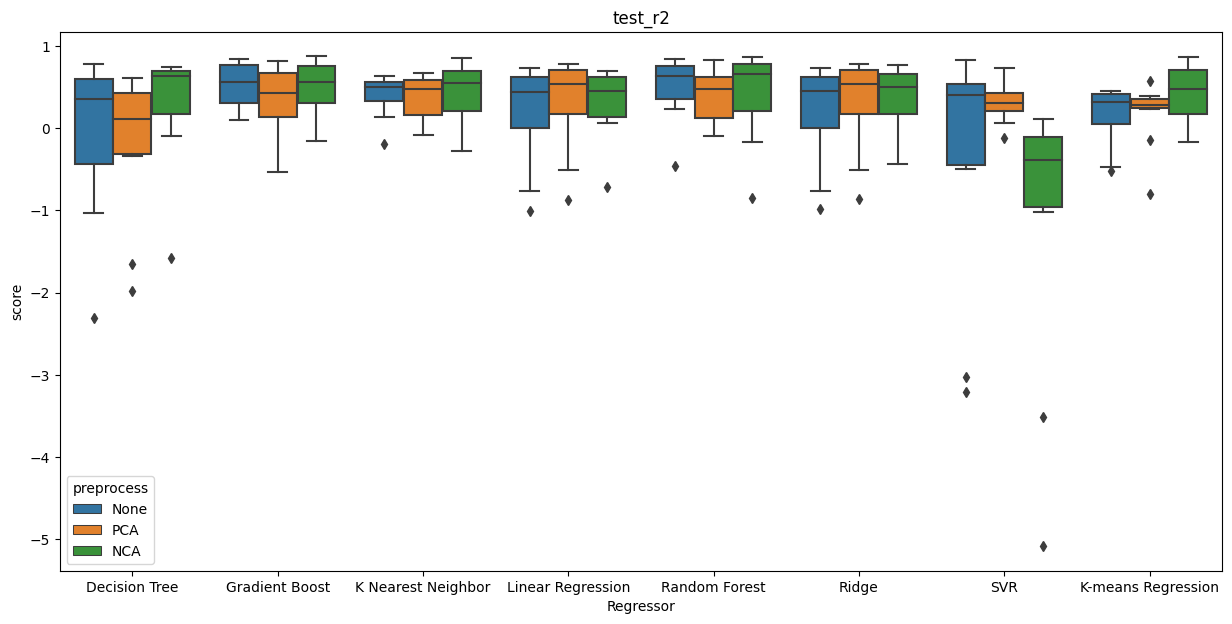

In [18]:
for metric in ['fit_time', 'score_time', 'test_neg_mean_absolute_error',
       'test_neg_mean_squared_error', 'test_r2']:
    results_pd = pd.DataFrame(results[metric])
    results_ORG = pd.DataFrame()
    results_NCA = pd.DataFrame()
    results_PCA = pd.DataFrame()
    for name in results_pd:
        if name[:3] == "NCA":
            regressor = name[6:]
            results_NCA[regressor] = results_pd[name]
        elif name[:3] == "PCA":
            regressor = name[6:]
            results_PCA[regressor] = results_pd[name]
        else:
            regressor = name
            results_ORG[regressor] = results_pd[name]

    results_ORG.loc[:, "preprocess"] = "None"
    results_PCA.loc[:, "preprocess"] = "PCA"
    results_NCA.loc[:, "preprocess"] = "NCA"

    results_pd = pd.concat([results_ORG, results_PCA, results_NCA])

    plt.figure(figsize = (15, 7))
    sns.boxplot(
        data = results_pd.melt(id_vars=['preprocess'], value_vars=results_pd.columns[:-1],
                    var_name='Regressor', value_name="score"),
        x = "Regressor",
        y = "score",
        hue = "preprocess")
    plt.title(metric)
    plt.savefig(os.path.join(dir_out, f"boxplot_{metric}"), bbox_inches='tight')

In [6]:
def avg_results(results):
    results_avg = {}
    for key in results:
        results_avg[key] = {}
        for model_name in results[key]:
            results_avg[key][model_name] = np.mean(results[key][model_name])

    return results_avg
    
results_avg = avg_results(results)

Average performance

<Figure size 2000x1000 with 0 Axes>

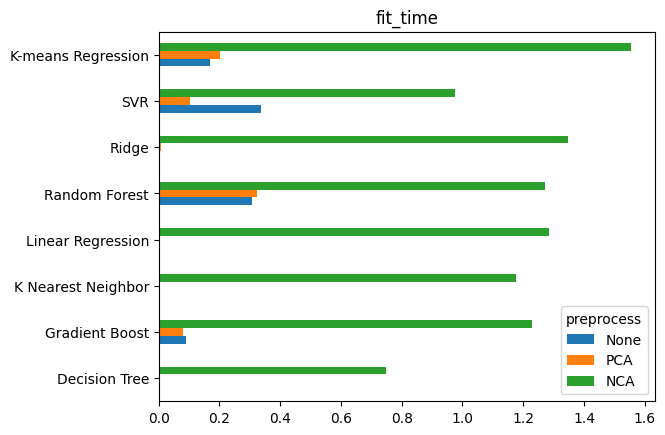

<Figure size 2000x1000 with 0 Axes>

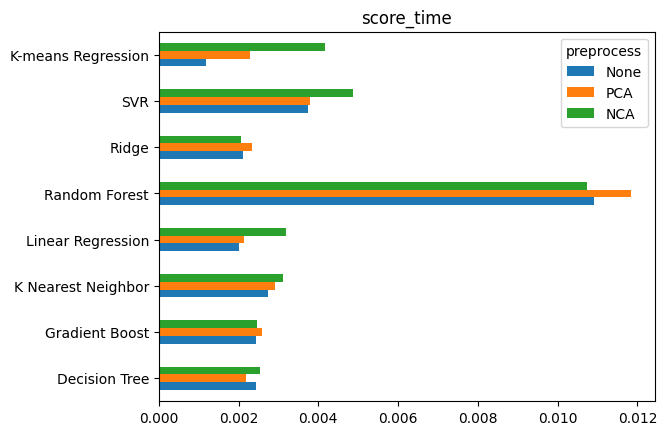

<Figure size 2000x1000 with 0 Axes>

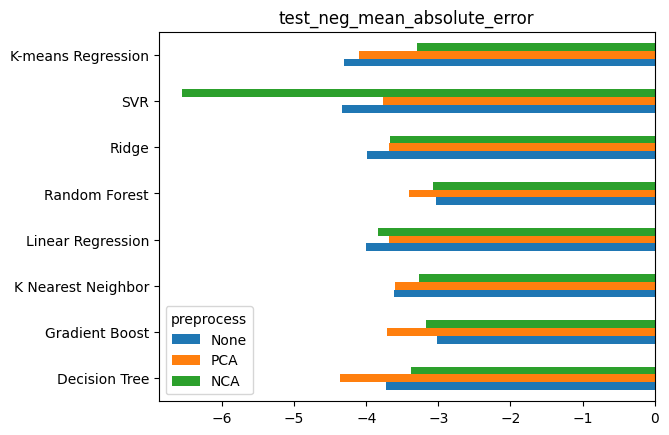

<Figure size 2000x1000 with 0 Axes>

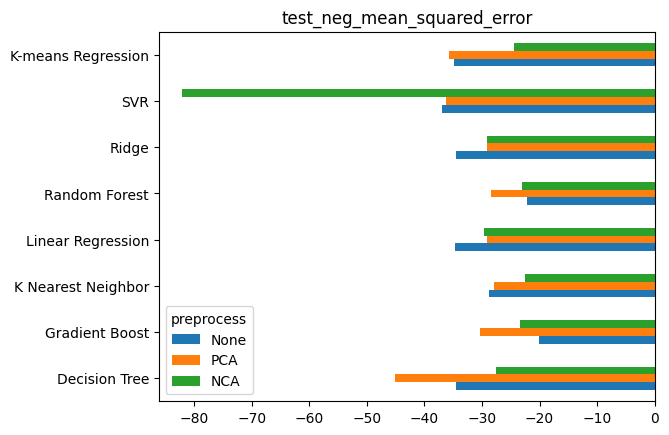

<Figure size 2000x1000 with 0 Axes>

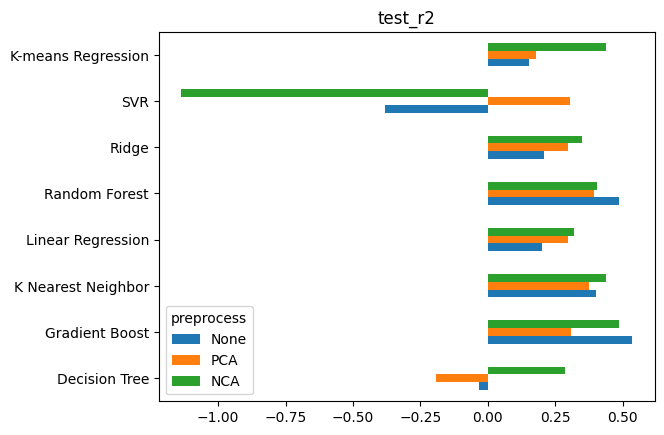

In [17]:
for metric in results_avg:
    results_pd = pd.DataFrame(results_avg[metric], index = [metric])
    results_ORG = pd.DataFrame()
    results_NCA = pd.DataFrame()
    results_PCA = pd.DataFrame()
    for name in results_pd:
        if name[:3] == "NCA":
            regressor = name[6:]
            results_NCA[regressor] = results_pd[name]
        elif name[:3] == "PCA":
            regressor = name[6:]
            results_PCA[regressor] = results_pd[name]
        else:
            regressor = name
            results_ORG[regressor] = results_pd[name]

    results_ORG.loc[:, "preprocess"] = "None"
    results_PCA.loc[:, "preprocess"] = "PCA"
    results_NCA.loc[:, "preprocess"] = "NCA"

    plt.figure(figsize = (20, 10))
    results_pd = pd.concat([results_ORG, results_PCA, results_NCA])
    results_pd.set_index("preprocess").transpose().plot.barh()
    plt.title(metric)
    plt.savefig(os.path.join(dir_out, f"barplot_{metric}"), bbox_inches='tight')